In [1]:
import openslide
from openslide import open_slide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Open slide
path = r"JP2K-33003-2.svs" # Heart tissue, brightfield, JPEG 2000, YCbCr
slide = open_slide(path)

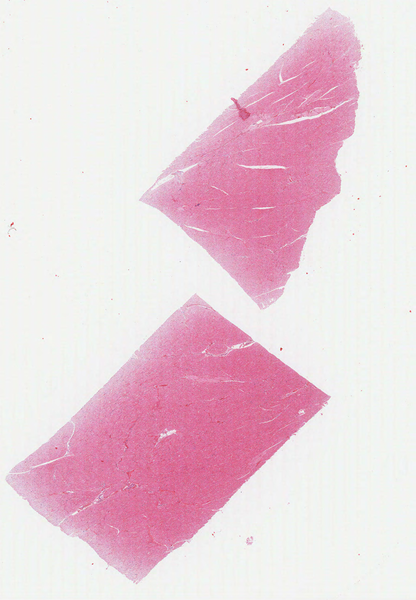

In [4]:
miniature = slide.get_thumbnail((600, 600))
display(miniature) 

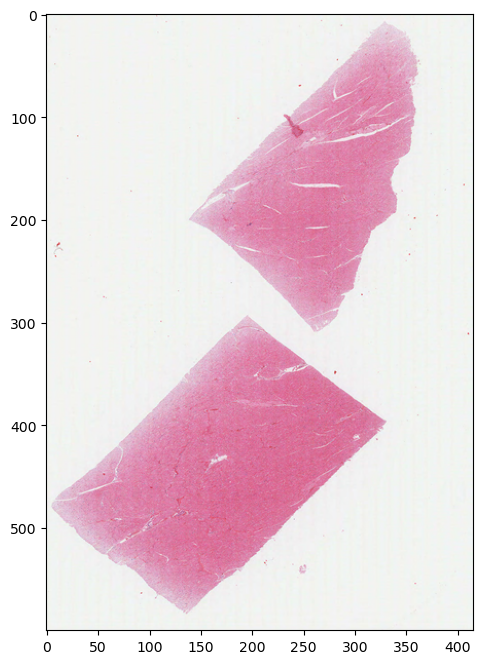

In [5]:
miniature_np = np.array(miniature)
plt.figure(figsize=(8,8))
plt.imshow(miniature_np)

In [30]:
slide_props = slide.properties
print(slide_props)

<_PropertyMap {'aperio.AppMag': '20', 'aperio.DSR ID': 'ap1757dsr', 'aperio.Date': '09/11/15', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': '99811', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '99811', 'aperio.Left': '23.405378', 'aperio.LineAreaXOffset': '0.017996', 'aperio.LineAreaYOffset': '-0.002221', 'aperio.LineCameraSkew': '0.000680', 'aperio.MPP': '0.5029', 'aperio.OriginalHeight': '38851', 'aperio.OriginalWidth': '52832', 'aperio.ScanScope ID': 'SS1757', 'aperio.StripeWidth': '2032', 'aperio.Time': '11:38:06', 'aperio.Time Zone': 'GMT-04:00', 'aperio.Title': 'NAT t', 'aperio.Top': '23.752468', 'aperio.User': '92ab1360-ab33-479d-b259-dd33d446f3a4', 'openslide.associated.macro.height': '627', 'openslide.associated.macro.width': '1600', 'openslide.associated.thumbnail.height': '766', 'openslide.associated.thumbnail.width': '1024', 'openslide.comment': 'Aperio Imag

In [31]:
slide.detect_format(path)

'aperio'

In [32]:
dims = slide.level_dimensions
print("Dimensions of various levels:", dims)

Dimensions of various levels: ((51791, 38751), (12947, 9687), (3236, 2421))


In [33]:
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

Number of levels in this image are: 3


In [34]:
# Other method for level count
slide.level_count

3

In [35]:
# downsampled level in each dimension
# x1.0 , x4.00.. , x16.004...
slide.level_downsamples

(1.0, 4.000270703657044, 16.005415569575852)

In [36]:
level3_dim = dims[2]

In [37]:
# read_region((pixel_x, pixel_y), level, dimensions)
level3_img = slide.read_region((0,0), 2, level3_dim)  # Pillow objcet, mode=RGBA

In [25]:
# Convrt to RGB
level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

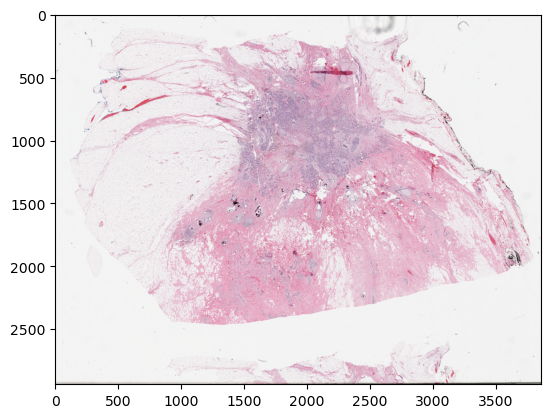

In [26]:
# Converto to np format
level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)

<h2>DeepZoomGenerator

In [2]:
from openslide.deepzoom import DeepZoomGenerator

In [7]:
# Generate objcet for tiles using DeepZoomGenerator
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
# here we divided our svs into tiles of size 256 with no overlap

In [8]:
# Extract properties
print("Number of levels in the tiles object are:", tiles.level_count)
print("The dimension of data in each level are: ", tiles.level_dimensions)
print("Total number of tiles = : ", tiles.tile_count)

Number of levels in the tiles object are: 17
The dimension of data in each level are:  ((1, 1), (1, 2), (2, 3), (4, 6), (8, 12), (16, 23), (32, 46), (64, 92), (128, 184), (256, 368), (511, 736), (1021, 1472), (2042, 2943), (4084, 5885), (8168, 11769), (16336, 23538), (32671, 47076))
Total number of tiles = :  31417


In [9]:
# Tiles count at specific level
level_num = 11
print("Tiles shape at level", level_num, " is: ", tiles.level_tiles[level_num])
print("This means there are", tiles.level_tiles[level_num][0]*tiles.level_tiles[level_num][1], "total tiles in this level, each 256x256, expect last that can be ") 

Tiles shape at level 11  is:  (4, 6)
This means there are 24 total tiles in this level, each 256x256, expect last that can be 


In [10]:
# Dimension of the tile (tiles size) for a specific tile from a specific layer
tile_dims = tiles.get_tile_dimensions(11, (1,1))
print(tile_dims)

(256, 256)


In [11]:
# Tile count at the highest resolution level (level 16 in our tiles)
tile_count_in_large_image = tiles.level_tiles[16]
print("Tiles count in largest image is: ", tile_count_in_large_image)

Tiles count in largest image is:  (128, 184)


In [12]:
single_tile = tiles.get_tile(16, (62, 70))
single_tile_RGB = single_tile.convert('RGB')
single_tile_RGB.show()

<h2>H&E Normalization</h2>


'''
<h2>Na Czym Polega Normalizacja H&E?</h2>
Barwienie H&E (Hematoksylina i Eozyna) polega na użyciu dwóch barwników:

<strong>Hematoksylina (H):</strong> Barwi jądra komórkowe na niebiesko/fioletowo.

<strong>Eozyna (E):</strong> Barwi cytoplazmę i tkankę łączną na różowo/czerwono.

Problem polega na tym, że w zależności od laboratorium, grubości preparatu, czasu barwienia czy odczynników, te kolory mogą się znacznie różnić. Jeden preparat może być bladoróżowy, a inny intensywnie fioletowo-czerwony.

Proces normalizacji polega na:

Rozdzieleniu Barwników (Dekompozycja Kolorów): Za pomocą algorytmów matematycznych, obraz RGB jest rozkładany na dwie osobne "mapy", które reprezentują stężenie hematoksyliny (H) i eozyny (E) w każdym pikselu.

Wyborze Obrazu Docelowego: Wybierasz jeden, wzorcowy kafelek, który Twoim zdaniem ma "idealną" kolorystykę. Będzie on szablonem dla wszystkich innych.

Transformacji i Połączeniu: Algorytm dopasowuje stężenia H i E w każdym przetwarzanym kafelku tak, aby odpowiadały profilowi kolorystycznemu obrazu docelowego. Następnie łączy je z powrotem, tworząc nowy, znormalizowany obraz RGB.
'''

In [13]:
from normalize_HnE import norm_HnE

In [14]:
#Extract a small region from the large file (level 0)
#Let us extract a region from somewhere in the middle - coords 16k, 16k
#Extract 1024,1024 region
smaller_region = slide.read_region((16000,16000), 0, (1024,1024))
smaller_region_RGB = smaller_region.convert('RGB')
smaller_region_np = np.array(smaller_region_RGB)

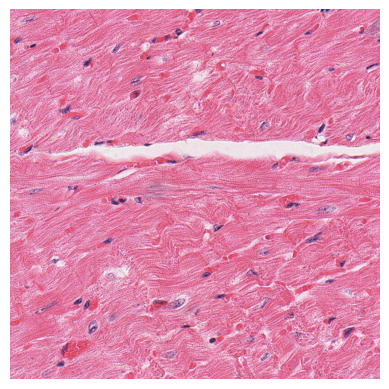

In [15]:
plt.axis('off')
plt.imshow(smaller_region_np)

In [16]:
norm_img, H_img, E_img = norm_HnE(smaller_region_np, Io=240, alpha=1, beta=0.15)

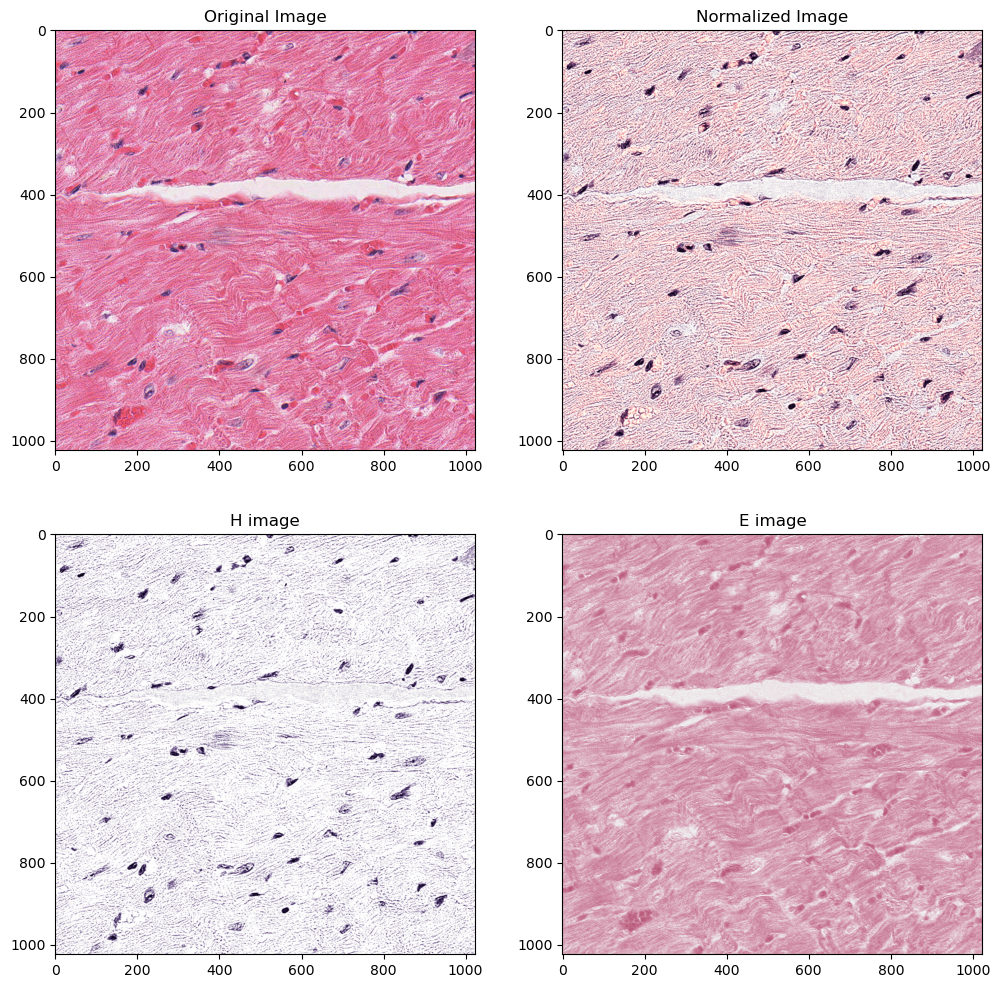

In [17]:
# Visualisation
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(smaller_region_np)
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()

<h2>Data extract for ML</h2>

<h3>Blank Images Handle</h3>

In [13]:
import tifffile as tiff
import os
import glob

In [14]:
def find_mean_std_pixel_value(img_list):
    
    avg_pixel_value = []
    stddev_pixel_value= []
    for file in img_list:
        image = tiff.imread(file)
        avg = image.mean()
        std = image.std()
        avg_pixel_value.append(avg)
        stddev_pixel_value.append(std)
        
    avg_pixel_value = np.array(avg_pixel_value)  
    stddev_pixel_value=np.array(stddev_pixel_value)
        
    print("Average pixel value for all images is:", avg_pixel_value.mean())
    print("Average std dev of pixel value for all images is:", stddev_pixel_value.mean())
    
    return(avg_pixel_value, stddev_pixel_value)

<h2>Data Extract</h2>
<p>Interesuje nas tylko poziom 17</p>
<p>Na tym poziomie dane mają rozdzielczość (32671, 47076)</p>
<p>Rozmiar kafelka to 256x256</p>
<p>Liczba kolumn: $\lceil 32671 / 256 \rceil = 128$</p>
<p>Liczba wierszy: $\lceil 47076 / 256 \rceil = 184$</p>
<p>Oznacza to, że na poziomie 16 mamy siatkę $128 \times 184$ kafelków.
Maksymalna liczba danych treningowych to $128 \times 184 = 23 552$ kafelki</p>
<p>Część odrzucamy jako puste</p>

In [15]:
cols , rows = tiles.level_tiles[16]

In [18]:
original_dir_name = "Svs_tiles/OriginalTiles"
normalized_dir_name = "Svs_tiles/NormalizedTiles"
H_tile_dir_name = "Svs_tiles/H_tiles"
E_tile_dir_name = "Svs_tiles/E_tiles"

In [19]:
os.makedirs(original_dir_name, exist_ok=True)
os.makedirs(normalized_dir_name, exist_ok=True)
os.makedirs(H_tile_dir_name, exist_ok=True)
os.makedirs(E_tile_dir_name, exist_ok=True)

In [20]:
for row in range(rows):
    for col in range(cols):
        tile_name = f"{col}_{row}" 
        
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        
        # Stwórz pełną ścieżkę dla oryginalnego kafelka i zapisz go
        original_path = os.path.join(original_dir_name, f"{tile_name}_original.tif")
        tiff.imwrite(original_path, temp_tile_np)

        # Sprawdź, czy kafelek zawiera tkankę
        if temp_tile_np.mean() < 230 and temp_tile_np.std() > 15:
            print("Processing tile number:", tile_name)
            
            # Znormalizuj obraz
            norm_img, H_img, E_img = norm_HnE(temp_tile_np, Io=240, alpha=1, beta=0.15)
            
            # pełne ścieżki dla każdego typu pliku
            normalized_path = os.path.join(normalized_dir_name, f"{tile_name}_norm.tif")
            H_path = os.path.join(H_tile_dir_name, f"{tile_name}_H.tif")
            E_path = os.path.join(E_tile_dir_name, f"{tile_name}_E.tif")
            
            # Zapisz pliki w odpowiednich lokalizacjach
            tiff.imwrite(normalized_path, norm_img)
            tiff.imwrite(H_path, H_img)
            tiff.imwrite(E_path, E_img)
            
        else:
            print("NOT PROCESSING TILE:", tile_name)

NOT PROCESSING TILE: 0_0
NOT PROCESSING TILE: 1_0
NOT PROCESSING TILE: 2_0
NOT PROCESSING TILE: 3_0
NOT PROCESSING TILE: 4_0
NOT PROCESSING TILE: 5_0
NOT PROCESSING TILE: 6_0
NOT PROCESSING TILE: 7_0
NOT PROCESSING TILE: 8_0
NOT PROCESSING TILE: 9_0
NOT PROCESSING TILE: 10_0
NOT PROCESSING TILE: 11_0
NOT PROCESSING TILE: 12_0
NOT PROCESSING TILE: 13_0
NOT PROCESSING TILE: 14_0
NOT PROCESSING TILE: 15_0
NOT PROCESSING TILE: 16_0
NOT PROCESSING TILE: 17_0
NOT PROCESSING TILE: 18_0
NOT PROCESSING TILE: 19_0
NOT PROCESSING TILE: 20_0
NOT PROCESSING TILE: 21_0
NOT PROCESSING TILE: 22_0
NOT PROCESSING TILE: 23_0
NOT PROCESSING TILE: 24_0
NOT PROCESSING TILE: 25_0
NOT PROCESSING TILE: 26_0
NOT PROCESSING TILE: 27_0
NOT PROCESSING TILE: 28_0
NOT PROCESSING TILE: 29_0
NOT PROCESSING TILE: 30_0
NOT PROCESSING TILE: 31_0
NOT PROCESSING TILE: 32_0
NOT PROCESSING TILE: 33_0
NOT PROCESSING TILE: 34_0
NOT PROCESSING TILE: 35_0
NOT PROCESSING TILE: 36_0
NOT PROCESSING TILE: 37_0
NOT PROCESSING TILE: 3

KeyboardInterrupt: 

<h1>Web DZI file generator</h1>

In [ ]:
import openslide
from openslide.deepzoom import DeepZoomGenerator
import os
import sys
import numpy as np
from PIL import Image
import time

# --- 0. Import Normalizatora ---
try:
    from normalize_HnE import norm_HnE 
    print("✅ Pomyślnie zaimportowano normalize_HnE.py")
except ImportError:
    print(f"🟥 BŁĄD KRYTYCZNY: Nie znaleziono pliku normalize_HnE.py!")
    exit()

# --- NOWY KROK: Dodanie filtra tkanki ---
# To jest ta sama funkcja, której używaliśmy podczas treningu
MAX_MEAN_THRESHOLD = 215 # Próg bieli (im niżej, tym ciemniejszy musi być kafelek)
MIN_STD_THRESHOLD = 20   # Próg "różnorodności" (jak bardzo płaski jest obraz)

def has_tissue(tile_image: Image.Image) -> bool:
    """Sprawdza, czy kafelek zawiera tkankę, a nie jest pustym tłem."""
    try:
        # Konwertuj do skali szarości (szybsza analiza)
        tile_np = np.array(tile_image.convert('L'))
        mean_val = np.mean(tile_np)
        std_val = np.std(tile_np)
        
        # Jeśli obraz jest "ciemny" (poniżej progu bieli)
        # ORAZ "różnorodny" (powyżej progu płaskości) -> uznaj za tkankę
        if mean_val < MAX_MEAN_THRESHOLD and std_val > MIN_STD_THRESHOLD:
            return True
        else:
            return False # To jest tło
    except Exception as e:
        return False
        
print(f"✅ Filtr tkanki (has_tissue) gotowy.")

# --- 1. Konfiguracja Ścieżek ---
source_scan_path = "99817.svs" 
output_base_name = "scans/breast_scan2" 
tile_format = "png" 

# --- 2. Inicjalizacja Generatora ---
try:
    slide = openslide.open_slide(source_scan_path)
    tiles = DeepZoomGenerator(slide, 
                              tile_size=254, 
                              overlap=1, 
                              limit_bounds=False)
except Exception as e:
    print(f"Nie udało się otworzyć pliku SVS: {e}")
    exit()
print(f"Pomyślnie wczytano skan: {source_scan_path}")

# --- 3. Krok A: Zapis Pliku .dzi ---
dzi_file_path = f"{output_base_name}.dzi"
try:
    os.makedirs(os.path.dirname(dzi_file_path), exist_ok=True)
    dzi_xml_content = tiles.get_dzi(format=tile_format)
    with open(dzi_file_path, "w") as f:
        f.write(dzi_xml_content)
    print(f"Pomyślnie zapisano plik DZI: {dzi_file_path}")
except Exception as e:
    print(f"Błąd podczas zapisu pliku DZI: {e}")
    exit()

# --- 4. Krok B: Zapis Kafelków (z filtrem) ---
tile_folder_path = f"{output_base_name}_files"
os.makedirs(tile_folder_path, exist_ok=True)
print(f"Rozpoczynam zapisywanie kafelków (z filtrem tkanki) do: {tile_folder_path}")

start_time = time.time()
total_tiles = 0
normalized_tiles = 0

try:
    for level in range(tiles.level_count):
        level_dir = os.path.join(tile_folder_path, str(level))
        os.makedirs(level_dir, exist_ok=True)
        
        cols, rows = tiles.level_tiles[level]
        level_tiles = cols * rows
        total_tiles += level_tiles
        
        print(f"  Przetwarzam Poziom {level}: {cols} x {rows} kafelków...")
        
        for row in range(rows):
            for col in range(cols):
                tile = tiles.get_tile(level, (col, row))
                
                # --- POCZĄTEK MODYFIKACJI (Filtr tkanki) ---
                
                # Sprawdź, czy na kafelku jest tkanka
                if has_tissue(tile):
                    # Jeśli tak, znormalizuj go
                    try:
                        tile_np = np.array(tile.convert('RGB'))
                        norm_img_np, _, _ = norm_HnE(tile_np)
                        tile_to_save = Image.fromarray(norm_img_np)
                        normalized_tiles += 1
                    except Exception as e:
                        # Normalizacja zawiodła, zapisz oryginał
                        tile_to_save = tile 
                else:
                    # Jeśli to tło, po prostu zapisz oryginał (bez normalizacji)
                    tile_to_save = tile
                    
                # --- KONIEC MODYFIKACJI ---

                tile_path = os.path.join(level_dir, f"{col}_{row}.{tile_format}")
                tile_to_save.save(tile_path)

    end_time = time.time()
    print("\nGotowe! Wszystkie kafelki zostały wygenerowane.")
    print(f"Całkowity czas: {(end_time - start_time) / 60:.2f} minut.")
    print(f"Łącznie przetworzono: {total_tiles} kafelków.")
    print(f"Znormalizowano (z tkanką): {normalized_tiles} kafelków.")
    
except Exception as e:
    print(f"\nWystąpił błąd podczas generowania kafelków: {e}")

✅ Pomyślnie zaimportowano normalize_HnE.py
✅ Filtr tkanki (has_tissue) gotowy.
Pomyślnie wczytano skan: 99817.svs
Pomyślnie zapisano plik DZI: scans/breast_scan2.dzi
Rozpoczynam zapisywanie kafelków (z filtrem tkanki) do: scans/breast_scan2_files
  Przetwarzam Poziom 0: 1 x 1 kafelków...
  Przetwarzam Poziom 1: 1 x 1 kafelków...
  Przetwarzam Poziom 2: 1 x 1 kafelków...
  Przetwarzam Poziom 3: 1 x 1 kafelków...
  Przetwarzam Poziom 4: 1 x 1 kafelków...
  Przetwarzam Poziom 5: 1 x 1 kafelków...
  Przetwarzam Poziom 6: 1 x 1 kafelków...
  Przetwarzam Poziom 7: 1 x 1 kafelków...
  Przetwarzam Poziom 8: 1 x 1 kafelków...
  Przetwarzam Poziom 9: 2 x 2 kafelków...
  Przetwarzam Poziom 10: 4 x 3 kafelków...
  Przetwarzam Poziom 11: 7 x 6 kafelków...
  Przetwarzam Poziom 12: 14 x 12 kafelków...
  Przetwarzam Poziom 13: 27 x 24 kafelków...
